# Analysing a regular ECG signal

In this notebook I’ll show you three examples of using HeartPy to
analyse good-to-reasonable quality ECG signals you may encounter.

We’ll be looking at three excerpts from the [European ST-T Database over
at Physionet](https://physionet.org/content/edb/1.0.0/). There are all
recorded at 250 Hz

In [1]:
#import packages
import heartpy as hp
import matplotlib.pyplot as plt

sample_rate = 250

Let’s look at the first file and visualise it:

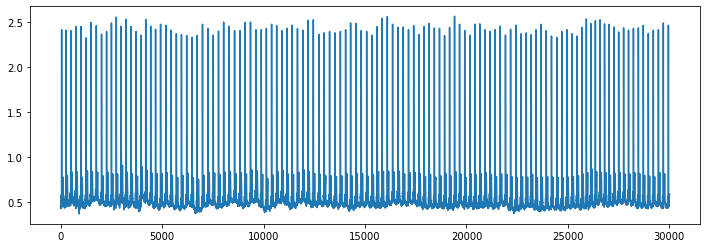

In [2]:
data = hp.get_data('e0103.csv')

plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

That is a very nice and clean signal. We don’t need to do any
preprocessing and can run analysis right away:

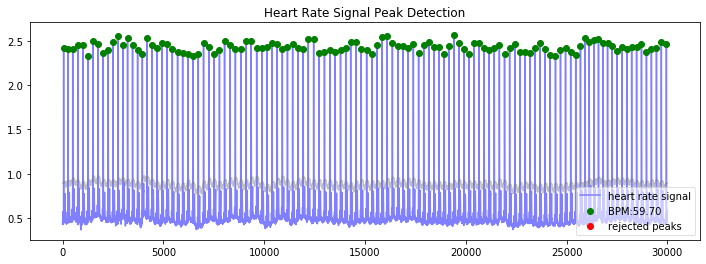

bpm: 59.697000
ibi: 1005.075630
sdnn: 45.612021
sdsd: 17.278462
rmssd: 30.487563
pnn20: 0.483051
pnn50: 0.118644
hr_mad: 28.000000
sd1: 21.545153
sd2: 59.911382
s: 4055.167506
sd1/sd2: 0.359617
breathingrate: 0.166667

In [3]:
#run analysis
wd, m = hp.process(data, sample_rate)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

#### That went well.

Now let’s move on to the next one and see if we can analyse that one
too:

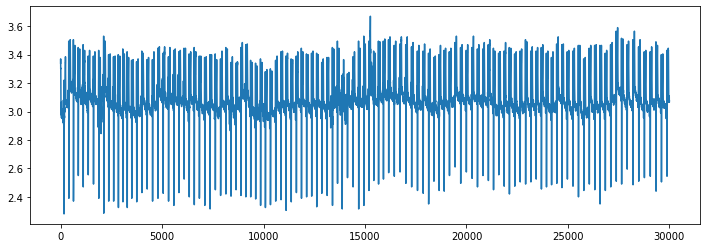

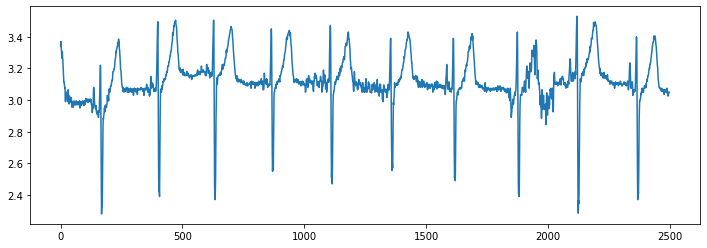

In [4]:
data = hp.get_data('e0110.csv')

plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

#and zoom in a bit
plt.figure(figsize=(12,4))
plt.plot(data[0:2500])
plt.show()

#### Ah!

We have an issue where the T-wave (the broad wave right after the main
QRS complex) is present. We can filter this using a notch filter, as
we’re interested in the QRS comples.

What the notch filter does is apply a frequency filter to a very narrow
frequency range, allowing us to get rid of some things without
disturbing the QRS complexes.

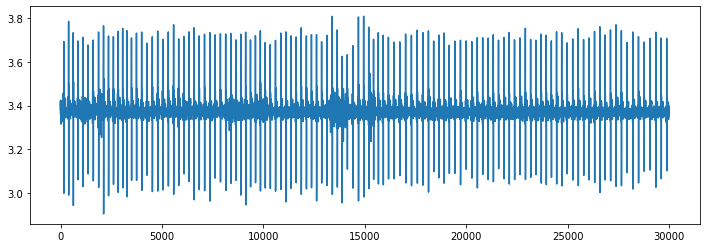

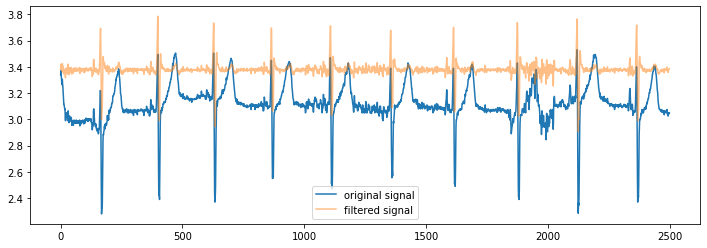

In [5]:
filtered = hp.filter_signal(data, cutoff = 0.05, sample_rate = sample_rate, filtertype='notch')

#visualize again
plt.figure(figsize=(12,4))
plt.plot(filtered)
plt.show()

#and zoom in a bit
plt.figure(figsize=(12,4))
plt.plot(data[0:2500], label = 'original signal')
plt.plot(filtered[0:2500], alpha=0.5, label = 'filtered signal')
plt.legend()
plt.show()

#### We’ve now reduced the amplitude of the T-wave and are ready for analysis

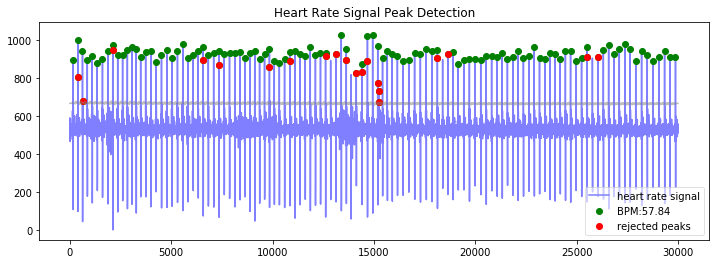

bpm: 57.843015
ibi: 1037.290323
sdnn: 60.906871
sdsd: 20.513036
rmssd: 33.059617
pnn20: 0.493827
pnn50: 0.135802
hr_mad: 36.000000
sd1: 23.285718
sd2: 84.305770
s: 6167.324586
sd1/sd2: 0.276206
breathingrate: 0.075000

In [6]:
#run analysis
wd, m = hp.process(hp.scale_data(filtered), sample_rate)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

#### Oh dear

HeartPy is distrusting some peaks. This is because HeartPy’s optimizer
likes broader peaks than some ECG recordings provide (especially lower
sampling rates). Usually when filtering the peak width decreases as
well, potentially causing issues.

The solution is simple. We can upsample the signal using
[scipy.signal.resample](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.resample.html)
to help with this!

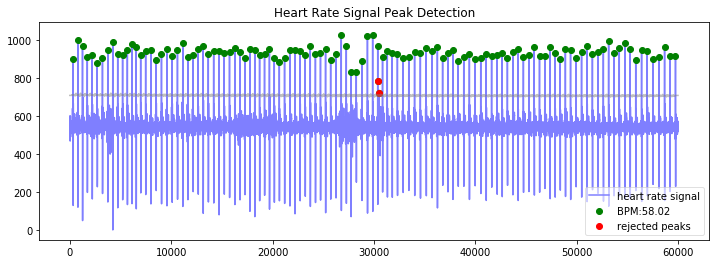

bpm: 58.018220
ibi: 1034.157895
sdnn: 59.536305
sdsd: 21.549303
rmssd: 34.825073
pnn20: 0.544643
pnn50: 0.133929
hr_mad: 35.000000
sd1: 24.588644
sd2: 80.051446
s: 6183.774312
sd1/sd2: 0.307161
breathingrate: 0.116667

In [7]:
from scipy.signal import resample

#resample the data. Usually 2, 4, or 6 times is enough depending on original sampling rate
resampled_data = resample(filtered, len(filtered) * 2)

#And run the analysis again. Don't forget to up the sample rate as well!
wd, m = hp.process(hp.scale_data(resampled_data), sample_rate * 2)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

Upsampling the signal has enabled HeartPy to optimize and find the
position for all peaks in the signal.

Note the use of ***hp.scale_data()*** in the processing function. This
is recommended when the amplitude is low (2.4-3.8 in the original data).

------------------------------------------------------------------------

Let’s look at the last example

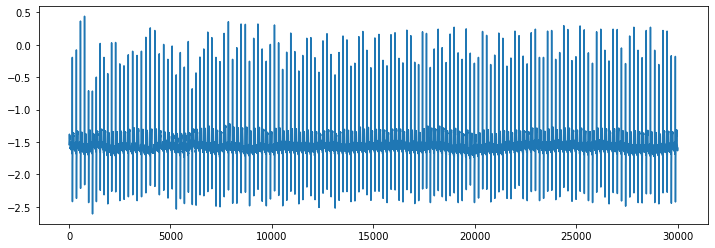

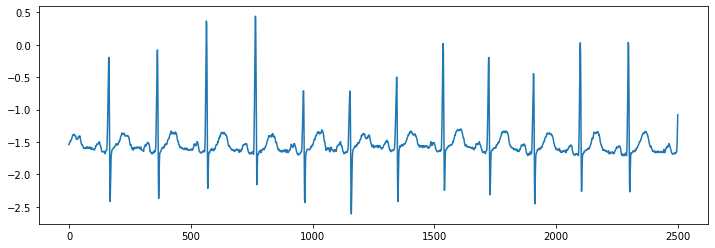

In [8]:
data = hp.get_data('e0124.csv')

plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

#and zoom in a bit
plt.figure(figsize=(12,4))
plt.plot(data[0:2500])
plt.show()

Again we have a very strong signal present in the recording. That is
always nice to see. Analysis again is then straightforward:

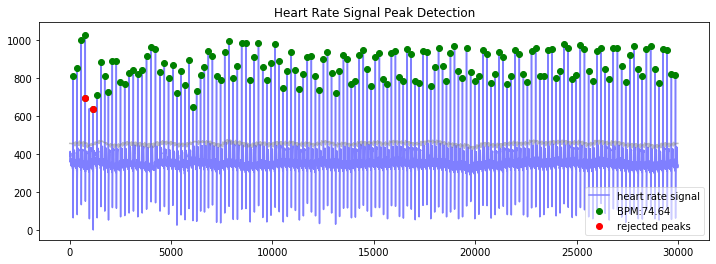

bpm: 74.642232
ibi: 803.834483
sdnn: 25.854237
sdsd: 8.060314
rmssd: 13.118076
pnn20: 0.104895
pnn50: 0.000000
hr_mad: 16.000000
sd1: 9.272843
sd2: 35.470837
s: 1033.318549
sd1/sd2: 0.261422
breathingrate: 0.175000

In [9]:
#run analysis
wd, m = hp.process(hp.scale_data(data), sample_rate)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

#### And again we can fix the ‘mistrusted’ peaks with modest upsampling

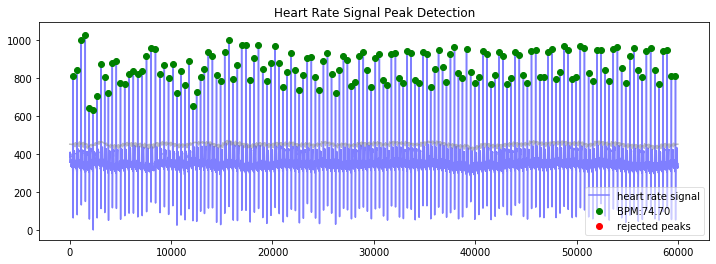

bpm: 74.700944
ibi: 803.202703
sdnn: 25.987252
sdsd: 8.037765
rmssd: 13.000262
pnn20: 0.095238
pnn50: 0.000000
hr_mad: 14.000000
sd1: 9.192447
sd2: 35.707405
s: 1031.191456
sd1/sd2: 0.257438
breathingrate: 0.125000

In [10]:
#resample the data. Usually 2, 4, or 6 times is enough depending on original sampling rate
resampled_data = resample(data, len(filtered) * 2)

#And run the analysis again. Don't forget to up the sample rate as well!
wd, m = hp.process(hp.scale_data(resampled_data), sample_rate * 2)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

## Since 1.2.4 HeartPy includes Poincaré nonlinear methods too

Use them like the plotter function:

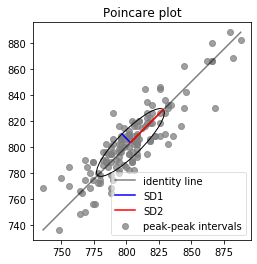


nonlinear poincare measures:
sd1: 9.192447
sd2: 35.707405
s: 1031.191456
sd1/sd2: 0.257438

In [11]:
hp.plot_poincare(wd, m)

#print poincare measures
poincare_measures = ['sd1', 'sd2', 's', 'sd1/sd2']
print('\nnonlinear poincare measures:')
for measure in poincare_measures:
    print('%s: %f' %(measure, m[measure]))

## That’s it!

I hope this notebook has given you an overview of how to analyse good to
medium quality ECG data.

There’s also a more advanced notebook available on the repository on
[how to handle poor quality ECG
data](https://github.com/paulvangentcom/heartrate_analysis_python/blob/master/examples/5_noisy_ECG/Analysing_Noisy_ECG.ipynb).